In [29]:
# Fixed Real Data Fetcher for TSMOM Strategy
# Handles MultiIndex columns and missing Adj Close issues

import yfinance as yf
import pandas as pd
import numpy as np
import warnings
from datetime import datetime, timedelta
import time

warnings.filterwarnings('ignore')

class FixedRealDataFetcher:
    """
    Fixed version of RealDataFetcher that handles MultiIndex columns
    and missing Adj Close columns properly
    """

    def __init__(self):
        # Use verified working tickers
        self.asset_mapping = {
            # COMMODITIES (Energy)
            # 'CL=F': 'Crude_Oil',
            # 'NG=F': 'Natural_Gas',
            # 'RB=F': 'Gasoline',
            # 'HO=F': 'Heating_Oil',

            # # COMMODITIES (Metals)
            # 'GC=F': 'Gold',
            # 'SI=F': 'Silver',
            # 'HG=F': 'Copper',
            # 'PL=F': 'Platinum',
            # 'PA=F': 'Palladium',

            # COMMODITIES (Agriculture)
            'ZC=F': 'Corn',
            # 'ZW=F': 'Wheat',
            # 'ZS=F': 'Soybeans',
            # 'ZM=F': 'Soy_Meal',
            # 'ZL=F': 'Soy_Oil',
            # 'SB=F': 'Sugar',
            # 'CC=F': 'Cocoa',
            'KC=F': 'Coffee',
            # 'CT=F': 'Cotton',
            'HE=F': 'Lean_Hogs',
            # 'LE=F': 'Live_Cattle',

            # EQUITY INDICES
            '^GSPC': 'SP500',
            # '^FTSE': 'FTSE100',
            # '^GDAXI': 'DAX',
            # '^FCHI': 'CAC40',
            # '^N225': 'Nikkei225',
            # '^AEX': 'AEX',
            # '^IBEX': 'IBEX35',

            # CURRENCIES
            'USDTRY=X': 'USD/터키 리라',
            'EURUSD=X': 'EUR/USD',
            # 'GBPUSD=X': 'GBP_USD',
            # 'USDJPY=X': 'USD_JPY',
            # 'USDCAD=X': 'USD_CAD',
            # 'AUDUSD=X': 'AUD_USD',
            # 'NZDUSD=X': 'NZD_USD',
            # 'USDCHF=X': 'USD_CHF',
            # 'EURGBP=X': 'EUR_GBP',
            # 'EURJPY=X': 'EUR_JPY',
            # 'AUDJPY=X': 'AUD_JPY',

            # GOVERNMENT BONDS (Yields)
            # '^TNX': 'US_10Y_Yield',
            # '^TYX': 'US_30Y_Yield',
            # '^FVX': 'US_5Y_Yield',
            '^IRX': 'US_3M_Yield',
            'TIPS': '물가연동국채',
            'SHY': '단기 국채 ETF',

            # # BOND FUTURES
            # 'ZB=F': 'US_30Y_Bond',
            # 'ZN=F': 'US_10Y_Note',
            # 'ZF=F': 'US_5Y_Note',
            # 'ZT=F': 'US_2Y_Note',
        }

        self.asset_classes = {
            # Commodities
            'Crude_Oil': 'Commodities', 'Natural_Gas': 'Commodities', 'Gasoline': 'Commodities',
            'Heating_Oil': 'Commodities', 'Gold': 'Commodities', 'Silver': 'Commodities',
            'Copper': 'Commodities', 'Platinum': 'Commodities', 'Palladium': 'Commodities',
            'Corn': 'Commodities', 'Wheat': 'Commodities', 'Soybeans': 'Commodities',
            'Soy_Meal': 'Commodities', 'Soy_Oil': 'Commodities', 'Sugar': 'Commodities',
            'Cocoa': 'Commodities', 'Coffee': 'Commodities', 'Cotton': 'Commodities',
            'Lean_Hogs': 'Commodities', 'Live_Cattle': 'Commodities',

            # Equities
            'SP500': 'Equities', 'FTSE100': 'Equities', 'DAX': 'Equities',
            'CAC40': 'Equities', 'Nikkei225': 'Equities', 'AEX': 'Equities', 'IBEX35': 'Equities',

            # Currencies
            'EUR_USD': 'Currencies', 'GBP_USD': 'Currencies', 'USD_JPY': 'Currencies',
            'USD_CAD': 'Currencies', 'AUD_USD': 'Currencies', 'NZD_USD': 'Currencies',
            'USD_CHF': 'Currencies', 'EUR_GBP': 'Currencies', 'EUR_JPY': 'Currencies',
            'AUD_JPY': 'Currencies',

            # Fixed Income
            'US_10Y_Yield': 'Fixed_Income', 'US_30Y_Yield': 'Fixed_Income',
            'US_5Y_Yield': 'Fixed_Income', 'US_3M_Yield': 'Fixed_Income',
            'US_30Y_Bond': 'Fixed_Income', 'US_10Y_Note': 'Fixed_Income',
            'US_5Y_Note': 'Fixed_Income', 'US_2Y_Note': 'Fixed_Income',
        }

    def _flatten_columns(self, data):
        """Flatten MultiIndex columns if present"""
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = data.columns.get_level_values(0)
        return data

    def _find_price_column(self, data):
        """Find the best price column to use"""
        # Handle MultiIndex first
        data = self._flatten_columns(data)

        # Priority order
        priority_columns = ['Adj Close', 'Close', 'Price', 'Last']

        for col in priority_columns:
            if col in data.columns:
                return col, data[col]

        # If no standard columns, use first numeric column
        numeric_cols = data.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            return numeric_cols[0], data[numeric_cols[0]]

        return None, None

    def _fetch_single_asset(self, ticker, asset_name, start_date, end_date, min_data_points):
        """Fetch data for a single asset with robust error handling"""
        try:
            # Fetch raw data
            data = yf.download(ticker, start=start_date, end=end_date, progress=False)

            if data.empty:
                return None, f"Empty dataset for {ticker}"

            # Find price column
            price_col_name, price_series = self._find_price_column(data)

            if price_series is None:
                return None, f"No price column found for {ticker}"

            # Check data quality
            price_series = price_series.dropna()
            if len(price_series) < min_data_points:
                return None, f"Insufficient data: {len(price_series)} < {min_data_points}"

            return price_series, f"Success using '{price_col_name}'"

        except Exception as e:
            return None, f"Error: {str(e)}"

    def fetch_data(self, start_date='2010-01-01', end_date=None, min_data_points=500):
        """
        Fetch real price data with robust error handling

        Parameters:
        -----------
        start_date : str
            Start date for data fetching
        end_date : str, optional
            End date for data fetching
        min_data_points : int
            Minimum required data points

        Returns:
        --------
        tuple : (prices_df, metadata)
        """
        if end_date is None:
            end_date = datetime.now().strftime('%Y-%m-%d')

        print(f"🔄 Fetching data from {start_date} to {end_date}")
        print(f"📊 Assets to fetch: {len(self.asset_mapping)}")
        print("=" * 60)

        successful_data = {}
        failed_assets = {}

        for i, (ticker, asset_name) in enumerate(self.asset_mapping.items(), 1):
            print(f"[{i:2d}/{len(self.asset_mapping)}] {asset_name:15s} ({ticker:10s})", end=" ")

            price_series, status = self._fetch_single_asset(
                ticker, asset_name, start_date, end_date, min_data_points
            )

            if price_series is not None:
                successful_data[asset_name] = price_series
                print(f"✅ {status}")
            else:
                failed_assets[asset_name] = status
                print(f"❌ {status}")

            # Rate limiting
            time.sleep(0.05)

        # Create DataFrame from successful fetches
        if successful_data:
            print(f"\n📊 Creating consolidated dataset...")
            prices_df = pd.DataFrame(successful_data)

            # Align dates and handle missing values
            prices_df = prices_df.sort_index()

            # Forward fill and drop rows with too many NaNs
            prices_df = prices_df.ffill()

            # Remove rows where more than 50% of assets have missing data
            threshold = len(prices_df.columns) * 0.5
            prices_df = prices_df.dropna(thresh=threshold)

            # Remove assets with too much missing data
            asset_completeness = prices_df.count() / len(prices_df)
            valid_assets = asset_completeness[asset_completeness >= 0.8].index
            prices_df = prices_df[valid_assets]

            print(f"✅ Dataset created successfully!")
            print(f"📅 Date range: {prices_df.index[0].strftime('%Y-%m-%d')} to {prices_df.index[-1].strftime('%Y-%m-%d')}")
            print(f"📊 Final shape: {prices_df.shape}")
            print(f"🎯 Success rate: {len(successful_data)}/{len(self.asset_mapping)} ({len(successful_data)/len(self.asset_mapping)*100:.1f}%)")

            # Asset class breakdown
            asset_class_counts = {}
            for asset in prices_df.columns:
                asset_class = self.asset_classes.get(asset, 'Unknown')
                asset_class_counts[asset_class] = asset_class_counts.get(asset_class, 0) + 1

            print(f"\n📋 Asset class breakdown:")
            for asset_class, count in asset_class_counts.items():
                print(f"  {asset_class}: {count} assets")

            metadata = {
                'successful_assets': list(successful_data.keys()),
                'failed_assets': failed_assets,
                'asset_classes': asset_class_counts,
                'date_range': (prices_df.index[0], prices_df.index[-1]),
                'total_observations': len(prices_df),
                'success_rate': len(successful_data)/len(self.asset_mapping)
            }

            return prices_df, metadata

        else:
            raise ValueError("No data was successfully fetched!")

    def get_benchmark_data(self, start_date='2010-01-01', end_date=None):
        """Fetch S&P 500 benchmark data"""
        if end_date is None:
            end_date = datetime.now().strftime('%Y-%m-%d')

        print("📈 Fetching S&P 500 benchmark...")

        price_series, status = self._fetch_single_asset('^GSPC', 'SP500', start_date, end_date, 100)

        if price_series is not None:
            print(f"✅ Benchmark data: {status}")
            return price_series
        else:
            print(f"❌ Benchmark failed: {status}")
            return None

    def get_risk_free_rate(self, start_date='2010-01-01', end_date=None):
        """Fetch 3-month Treasury yield as risk-free rate"""
        if end_date is None:
            end_date = datetime.now().strftime('%Y-%m-%d')

        print("🏛️ Fetching risk-free rate (3M Treasury)...")

        rate_series, status = self._fetch_single_asset('^IRX', '3M_Treasury', start_date, end_date, 100)

        if rate_series is not None:
            # Convert from percentage to decimal
            rate_series = rate_series / 100
            print(f"✅ Risk-free rate: {status}")
            print(f"📊 Average rate: {rate_series.mean():.2%}")
            return rate_series
        else:
            print(f"❌ Risk-free rate failed: {status}")
            print("🔄 Using constant 2% rate")
            return None

    def save_data(self, prices_df, filename='tsmom_fixed_data.csv'):
        """Save data to CSV"""
        try:
            prices_df.to_csv(filename)
            print(f"💾 Data saved to {filename}")
        except Exception as e:
            print(f"❌ Save failed: {str(e)}")

    def load_data(self, filename='tsmom_fixed_data.csv'):
        """Load data from CSV"""
        try:
            prices_df = pd.read_csv(filename, index_col=0, parse_dates=True)
            print(f"📂 Data loaded from {filename}")
            print(f"📊 Shape: {prices_df.shape}")
            return prices_df
        except Exception as e:
            print(f"❌ Load failed: {str(e)}")
            return None

def test_fixed_fetcher():
    """Test the fixed data fetcher"""
    print("🧪 Testing Fixed Data Fetcher")
    print("=" * 50)

    fetcher = FixedRealDataFetcher()

    # Test small sample first
    test_mapping = {
        'CL=F': 'Crude_Oil',
        'GC=F': 'Gold',
        '^GSPC': 'SP500',
        'EURUSD=X': 'EUR_USD',
        '^TNX': 'US_10Y_Yield'
    }

    print("🔬 Testing sample assets...")
    for ticker, name in test_mapping.items():
        price_series, status = fetcher._fetch_single_asset(ticker, name, '2020-01-01', '2024-12-31', 100)
        if price_series is not None:
            print(f"✅ {name:12s}: {status} ({len(price_series)} points)")
        else:
            print(f"❌ {name:12s}: {status}")

    return fetcher

def run_full_data_fetch():
    """Run full data fetching with the fixed fetcher"""
    print("🚀 Running Full Data Fetch")
    print("=" * 50)

    fetcher = FixedRealDataFetcher()

    try:
        # Fetch all data
        prices_df, metadata = fetcher.fetch_data(
            start_date='2015-01-01',  # Start from 2015 for better data availability
            end_date='2024-12-31',
            min_data_points=300
        )

        # Get benchmark
        sp500_data = fetcher.get_benchmark_data('2015-01-01', '2024-12-31')

        # Get risk-free rate
        risk_free_rate = fetcher.get_risk_free_rate('2015-01-01', '2024-12-31')

        # Save data
        fetcher.save_data(prices_df, 'tsmom_fixed_data.csv')

        print(f"\n🎉 Data fetch completed!")
        print(f"📊 Ready for TSMOM strategy with {len(prices_df.columns)} assets")

        return prices_df, sp500_data, risk_free_rate, metadata

    except Exception as e:
        print(f"❌ Data fetch failed: {str(e)}")
        return None, None, None, None

# Example usage
if __name__ == "__main__":
    print("🔧 Fixed Real Data Fetcher for TSMOM Strategy")
    print("=" * 60)

    # Option 1: Test small sample
    print("Option 1: Test sample assets")
    print("test_fixed_fetcher()")

    print("\nOption 2: Run full data fetch")
    print("prices_df, sp500, rf_rate, metadata = run_full_data_fetch()")

    print("\nOption 3: Load previously saved data")
    print("fetcher = FixedRealDataFetcher()")
    print("prices_df = fetcher.load_data('tsmom_fixed_data.csv')")

    # Uncomment to test
    # test_fixed_fetcher()

🔧 Fixed Real Data Fetcher for TSMOM Strategy
Option 1: Test sample assets
test_fixed_fetcher()

Option 2: Run full data fetch
prices_df, sp500, rf_rate, metadata = run_full_data_fetch()

Option 3: Load previously saved data
fetcher = FixedRealDataFetcher()
prices_df = fetcher.load_data('tsmom_fixed_data.csv')


In [19]:
# Fixed Real Data Fetcher for TSMOM Strategy
# Handles MultiIndex columns and missing Adj Close issues

import yfinance as yf
import pandas as pd
import numpy as np
import warnings
from datetime import datetime, timedelta
import time

warnings.filterwarnings('ignore')

class FixedRealDataFetcher:
    """
    Fixed version of RealDataFetcher that handles MultiIndex columns
    and missing Adj Close columns properly
    """

    def __init__(self):
        # Use verified working tickers
        self.asset_mapping = {
            # COMMODITIES (Energy)
            'CL=F': 'Crude_Oil',
            'NG=F': 'Natural_Gas',
            'RB=F': 'Gasoline',
            'HO=F': 'Heating_Oil',

            # COMMODITIES (Metals)
            'GC=F': 'Gold',
            'SI=F': 'Silver',
            'HG=F': 'Copper',
            'PL=F': 'Platinum',
            'PA=F': 'Palladium',

            # COMMODITIES (Agriculture)
            'ZC=F': 'Corn',
            'ZW=F': 'Wheat',
            'ZS=F': 'Soybeans',
            'ZM=F': 'Soy_Meal',
            'ZL=F': 'Soy_Oil',
            'SB=F': 'Sugar',
            'CC=F': 'Cocoa',
            'KC=F': 'Coffee',
            'CT=F': 'Cotton',
            'HE=F': 'Lean_Hogs',
            'LE=F': 'Live_Cattle',

            # EQUITY INDICES
            '^GSPC': 'SP500',
            '^FTSE': 'FTSE100',
            '^GDAXI': 'DAX',
            '^FCHI': 'CAC40',
            '^N225': 'Nikkei225',
            '^AEX': 'AEX',
            '^IBEX': 'IBEX35',

            # CURRENCIES
            'USDTRY=X': 'USD/터키 리라',
            'EURUSD=X': 'EUR/USD',
            'GBPUSD=X': 'GBP_USD',
            'USDJPY=X': 'USD_JPY',
            'USDCAD=X': 'USD_CAD',
            'AUDUSD=X': 'AUD_USD',
            'NZDUSD=X': 'NZD_USD',
            'USDCHF=X': 'USD_CHF',
            'EURGBP=X': 'EUR_GBP',
            'EURJPY=X': 'EUR_JPY',
            'AUDJPY=X': 'AUD_JPY',

            # GOVERNMENT BONDS (Yields)
            '^TNX': 'US_10Y_Yield',
            '^TYX': 'US_30Y_Yield',
            '^FVX': 'US_5Y_Yield',
            '^IRX': 'US_3M_Yield',
            'TIPS': '물가연동국채',
            'SHY': '단기 국채 ETF',

            # BOND FUTURES
            'ZB=F': 'US_30Y_Bond',
            'ZN=F': 'US_10Y_Note',
            'ZF=F': 'US_5Y_Note',
            'ZT=F': 'US_2Y_Note',
        }

        self.asset_classes = {
            # Commodities
            'Crude_Oil': 'Commodities', 'Natural_Gas': 'Commodities', 'Gasoline': 'Commodities',
            'Heating_Oil': 'Commodities', 'Gold': 'Commodities', 'Silver': 'Commodities',
            'Copper': 'Commodities', 'Platinum': 'Commodities', 'Palladium': 'Commodities',
            'Corn': 'Commodities', 'Wheat': 'Commodities', 'Soybeans': 'Commodities',
            'Soy_Meal': 'Commodities', 'Soy_Oil': 'Commodities', 'Sugar': 'Commodities',
            'Cocoa': 'Commodities', 'Coffee': 'Commodities', 'Cotton': 'Commodities',
            'Lean_Hogs': 'Commodities', 'Live_Cattle': 'Commodities',

            # Equities
            'SP500': 'Equities', 'FTSE100': 'Equities', 'DAX': 'Equities',
            'CAC40': 'Equities', 'Nikkei225': 'Equities', 'AEX': 'Equities', 'IBEX35': 'Equities',

            # Currencies
            'EUR_USD': 'Currencies', 'GBP_USD': 'Currencies', 'USD_JPY': 'Currencies',
            'USD_CAD': 'Currencies', 'AUD_USD': 'Currencies', 'NZD_USD': 'Currencies',
            'USD_CHF': 'Currencies', 'EUR_GBP': 'Currencies', 'EUR_JPY': 'Currencies',
            'AUD_JPY': 'Currencies',

            # Fixed Income
            'US_10Y_Yield': 'Fixed_Income', 'US_30Y_Yield': 'Fixed_Income',
            'US_5Y_Yield': 'Fixed_Income', 'US_3M_Yield': 'Fixed_Income',
            'US_30Y_Bond': 'Fixed_Income', 'US_10Y_Note': 'Fixed_Income',
            'US_5Y_Note': 'Fixed_Income', 'US_2Y_Note': 'Fixed_Income',
        }

    def _flatten_columns(self, data):
        """Flatten MultiIndex columns if present"""
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = data.columns.get_level_values(0)
        return data

    def _find_price_column(self, data):
        """Find the best price column to use"""
        # Handle MultiIndex first
        data = self._flatten_columns(data)

        # Priority order
        priority_columns = ['Adj Close', 'Close', 'Price', 'Last']

        for col in priority_columns:
            if col in data.columns:
                return col, data[col]

        # If no standard columns, use first numeric column
        numeric_cols = data.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            return numeric_cols[0], data[numeric_cols[0]]

        return None, None

    def _fetch_single_asset(self, ticker, asset_name, start_date, end_date, min_data_points):
        """Fetch data for a single asset with robust error handling"""
        try:
            # Fetch raw data
            data = yf.download(ticker, start=start_date, end=end_date, progress=False)

            if data.empty:
                return None, f"Empty dataset for {ticker}"

            # Find price column
            price_col_name, price_series = self._find_price_column(data)

            if price_series is None:
                return None, f"No price column found for {ticker}"

            # Check data quality
            price_series = price_series.dropna()
            if len(price_series) < min_data_points:
                return None, f"Insufficient data: {len(price_series)} < {min_data_points}"

            return price_series, f"Success using '{price_col_name}'"

        except Exception as e:
            return None, f"Error: {str(e)}"

    def fetch_data(self, start_date='2010-01-01', end_date=None, min_data_points=500):
        """
        Fetch real price data with robust error handling

        Parameters:
        -----------
        start_date : str
            Start date for data fetching
        end_date : str, optional
            End date for data fetching
        min_data_points : int
            Minimum required data points

        Returns:
        --------
        tuple : (prices_df, metadata)
        """
        if end_date is None:
            end_date = datetime.now().strftime('%Y-%m-%d')

        print(f"🔄 Fetching data from {start_date} to {end_date}")
        print(f"📊 Assets to fetch: {len(self.asset_mapping)}")
        print("=" * 60)

        successful_data = {}
        failed_assets = {}

        for i, (ticker, asset_name) in enumerate(self.asset_mapping.items(), 1):
            print(f"[{i:2d}/{len(self.asset_mapping)}] {asset_name:15s} ({ticker:10s})", end=" ")

            price_series, status = self._fetch_single_asset(
                ticker, asset_name, start_date, end_date, min_data_points
            )

            if price_series is not None:
                successful_data[asset_name] = price_series
                print(f"✅ {status}")
            else:
                failed_assets[asset_name] = status
                print(f"❌ {status}")

            # Rate limiting
            time.sleep(0.05)

        # Create DataFrame from successful fetches
        if successful_data:
            print(f"\n📊 Creating consolidated dataset...")
            prices_df = pd.DataFrame(successful_data)

            # Align dates and handle missing values
            prices_df = prices_df.sort_index()

            # Forward fill and drop rows with too many NaNs
            prices_df = prices_df.ffill()

            # Remove rows where more than 50% of assets have missing data
            threshold = len(prices_df.columns) * 0.5
            prices_df = prices_df.dropna(thresh=threshold)

            # Remove assets with too much missing data
            asset_completeness = prices_df.count() / len(prices_df)
            valid_assets = asset_completeness[asset_completeness >= 0.8].index
            prices_df = prices_df[valid_assets]

            print(f"✅ Dataset created successfully!")
            print(f"📅 Date range: {prices_df.index[0].strftime('%Y-%m-%d')} to {prices_df.index[-1].strftime('%Y-%m-%d')}")
            print(f"📊 Final shape: {prices_df.shape}")
            print(f"🎯 Success rate: {len(successful_data)}/{len(self.asset_mapping)} ({len(successful_data)/len(self.asset_mapping)*100:.1f}%)")

            # Asset class breakdown
            asset_class_counts = {}
            for asset in prices_df.columns:
                asset_class = self.asset_classes.get(asset, 'Unknown')
                asset_class_counts[asset_class] = asset_class_counts.get(asset_class, 0) + 1

            print(f"\n📋 Asset class breakdown:")
            for asset_class, count in asset_class_counts.items():
                print(f"  {asset_class}: {count} assets")

            metadata = {
                'successful_assets': list(successful_data.keys()),
                'failed_assets': failed_assets,
                'asset_classes': asset_class_counts,
                'date_range': (prices_df.index[0], prices_df.index[-1]),
                'total_observations': len(prices_df),
                'success_rate': len(successful_data)/len(self.asset_mapping)
            }

            return prices_df, metadata

        else:
            raise ValueError("No data was successfully fetched!")

    def get_benchmark_data(self, start_date='2010-01-01', end_date=None):
        """Fetch S&P 500 benchmark data"""
        if end_date is None:
            end_date = datetime.now().strftime('%Y-%m-%d')

        print("📈 Fetching S&P 500 benchmark...")

        price_series, status = self._fetch_single_asset('^GSPC', 'SP500', start_date, end_date, 100)

        if price_series is not None:
            print(f"✅ Benchmark data: {status}")
            return price_series
        else:
            print(f"❌ Benchmark failed: {status}")
            return None

    def get_risk_free_rate(self, start_date='2010-01-01', end_date=None):
        """Fetch 3-month Treasury yield as risk-free rate"""
        if end_date is None:
            end_date = datetime.now().strftime('%Y-%m-%d')

        print("🏛️ Fetching risk-free rate (3M Treasury)...")

        rate_series, status = self._fetch_single_asset('^IRX', '3M_Treasury', start_date, end_date, 100)

        if rate_series is not None:
            # Convert from percentage to decimal
            rate_series = rate_series / 100
            print(f"✅ Risk-free rate: {status}")
            print(f"📊 Average rate: {rate_series.mean():.2%}")
            return rate_series
        else:
            print(f"❌ Risk-free rate failed: {status}")
            print("🔄 Using constant 2% rate")
            return None

    def save_data(self, prices_df, filename='tsmom_fixed_data.csv'):
        """Save data to CSV"""
        try:
            prices_df.to_csv(filename)
            print(f"💾 Data saved to {filename}")
        except Exception as e:
            print(f"❌ Save failed: {str(e)}")

    def load_data(self, filename='tsmom_fixed_data.csv'):
        """Load data from CSV"""
        try:
            prices_df = pd.read_csv(filename, index_col=0, parse_dates=True)
            print(f"📂 Data loaded from {filename}")
            print(f"📊 Shape: {prices_df.shape}")
            return prices_df
        except Exception as e:
            print(f"❌ Load failed: {str(e)}")
            return None

def test_fixed_fetcher():
    """Test the fixed data fetcher"""
    print("🧪 Testing Fixed Data Fetcher")
    print("=" * 50)

    fetcher = FixedRealDataFetcher()

    # Test small sample first
    test_mapping = {
        'CL=F': 'Crude_Oil',
        'GC=F': 'Gold',
        '^GSPC': 'SP500',
        'EURUSD=X': 'EUR_USD',
        '^TNX': 'US_10Y_Yield'
    }

    print("🔬 Testing sample assets...")
    for ticker, name in test_mapping.items():
        price_series, status = fetcher._fetch_single_asset(ticker, name, '2020-01-01', '2024-12-31', 100)
        if price_series is not None:
            print(f"✅ {name:12s}: {status} ({len(price_series)} points)")
        else:
            print(f"❌ {name:12s}: {status}")

    return fetcher

def run_full_data_fetch():
    """Run full data fetching with the fixed fetcher"""
    print("🚀 Running Full Data Fetch")
    print("=" * 50)

    fetcher = FixedRealDataFetcher()

    try:
        # Fetch all data
        prices_df, metadata = fetcher.fetch_data(
            start_date='2015-01-01',  # Start from 2015 for better data availability
            end_date='2024-12-31',
            min_data_points=300
        )

        # Get benchmark
        sp500_data = fetcher.get_benchmark_data('2015-01-01', '2024-12-31')

        # Get risk-free rate
        risk_free_rate = fetcher.get_risk_free_rate('2015-01-01', '2024-12-31')

        # Save data
        fetcher.save_data(prices_df, 'tsmom_fixed_data.csv')

        print(f"\n🎉 Data fetch completed!")
        print(f"📊 Ready for TSMOM strategy with {len(prices_df.columns)} assets")

        return prices_df, sp500_data, risk_free_rate, metadata

    except Exception as e:
        print(f"❌ Data fetch failed: {str(e)}")
        return None, None, None, None

# Example usage
if __name__ == "__main__":
    print("🔧 Fixed Real Data Fetcher for TSMOM Strategy")
    print("=" * 60)

    # Option 1: Test small sample
    print("Option 1: Test sample assets")
    print("test_fixed_fetcher()")

    print("\nOption 2: Run full data fetch")
    print("prices_df, sp500, rf_rate, metadata = run_full_data_fetch()")

    print("\nOption 3: Load previously saved data")
    print("fetcher = FixedRealDataFetcher()")
    print("prices_df = fetcher.load_data('tsmom_fixed_data.csv')")

    # Uncomment to test
    # test_fixed_fetcher()

🔧 Fixed Real Data Fetcher for TSMOM Strategy
Option 1: Test sample assets
test_fixed_fetcher()

Option 2: Run full data fetch
prices_df, sp500, rf_rate, metadata = run_full_data_fetch()

Option 3: Load previously saved data
fetcher = FixedRealDataFetcher()
prices_df = fetcher.load_data('tsmom_fixed_data.csv')


In [8]:
# Time Series Momentum (TSMOM) Strategy with Risk Limits
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class TSMOMStrategyWithRiskLimits:
    """
    TSMOM Strategy with comprehensive risk management
    """

    def __init__(self, lookback_periods=[1, 3, 12], target_vol=0.40, portfolio_vol=0.10,
                 max_leverage=3.0, max_position_pct=0.20, max_drawdown=0.30,
                 var_limit=0.10, stop_loss_pct=0.15, max_correlation=0.80):
        """
        Parameters:
        -----------
        max_leverage : float, maximum gross leverage allowed
        max_position_pct : float, maximum position size as % of portfolio
        max_drawdown : float, maximum allowable drawdown before reducing exposure
        var_limit : float, Value at Risk limit (95% VaR)
        stop_loss_pct : float, stop loss threshold per position
        max_correlation : float, maximum average correlation allowed
        """
        self.lookback_periods = lookback_periods
        self.target_vol = target_vol
        self.portfolio_vol = portfolio_vol
        self.delta = self._calculate_delta()

        # Risk limits
        self.max_leverage = max_leverage
        self.max_position_pct = max_position_pct
        self.max_drawdown = max_drawdown
        self.var_limit = var_limit
        self.stop_loss_pct = stop_loss_pct
        self.max_correlation = max_correlation

        # Risk tracking
        self.position_entry_prices = {}
        self.portfolio_high_water_mark = 1.0
        self.current_portfolio_value = 1.0

    def _calculate_delta(self, center_of_mass=60):
        return 1 - 1/(center_of_mass + 1)

    def calculate_excess_returns(self, prices, risk_free_rate=0.02):
        returns = prices.pct_change().dropna()
        daily_rf = (1 + risk_free_rate) ** (1/252) - 1
        excess_returns = returns - daily_rf
        return excess_returns

    def calculate_volatility(self, returns):
        volatility = pd.DataFrame(index=returns.index, columns=returns.columns)

        for asset in returns.columns:
            asset_returns = returns[asset].dropna()
            vol_series = []

            for i in range(len(asset_returns)):
                if i < 60:
                    vol_series.append(np.nan)
                else:
                    recent_returns = asset_returns.iloc[max(0, i-252):i+1]
                    weights = [(1-self.delta) * (self.delta**j) for j in range(len(recent_returns))]
                    weights = weights[::-1]
                    weights = np.array(weights) / sum(weights)

                    mean_return = np.average(recent_returns, weights=weights)
                    variance = np.average((recent_returns - mean_return)**2, weights=weights)
                    annual_vol = np.sqrt(variance * 252)
                    vol_series.append(annual_vol)

            volatility[asset] = vol_series

        return volatility

    def generate_signals(self, excess_returns, lookback_months):
        lookback_days = lookback_months * 21
        cumulative_returns = excess_returns.rolling(window=lookback_days).sum()
        signals = np.where(cumulative_returns > 0, 1, -1)
        signals = pd.DataFrame(signals, index=excess_returns.index, columns=excess_returns.columns)
        return signals

    def calculate_position_sizes(self, signals, volatility):
        # Base position sizing
        position_sizes = signals * (self.target_vol / volatility)
        position_sizes = position_sizes.replace([np.inf, -np.inf], 0).fillna(0)

        # Apply position limits
        position_sizes = self._apply_position_limits(position_sizes)

        return position_sizes

    def _apply_position_limits(self, position_sizes):
        """Apply individual position size limits"""
        # Limit individual positions to max_position_pct
        position_sizes = position_sizes.clip(
            lower=-self.max_position_pct,
            upper=self.max_position_pct
        )
        return position_sizes

    def _apply_leverage_limit(self, position_sizes):
        """Apply portfolio leverage limit"""
        gross_leverage = position_sizes.abs().sum(axis=1)
        scaling_factor = pd.Series(1.0, index=gross_leverage.index)

        # Scale down if leverage exceeds limit
        over_leveraged = gross_leverage > self.max_leverage
        scaling_factor[over_leveraged] = self.max_leverage / gross_leverage[over_leveraged]

        # Apply scaling to all positions
        for col in position_sizes.columns:
            position_sizes[col] = position_sizes[col] * scaling_factor

        return position_sizes

    def _apply_drawdown_control(self, position_sizes, portfolio_returns):
        """Reduce exposure during drawdowns"""
        if len(portfolio_returns) == 0:
            return position_sizes

        # Calculate current drawdown
        cumulative_returns = (1 + portfolio_returns).cumprod()
        running_max = cumulative_returns.expanding().max()
        drawdown = (cumulative_returns / running_max) - 1
        current_dd = drawdown.iloc[-1] if len(drawdown) > 0 else 0

        # Scale positions based on drawdown
        if current_dd < -self.max_drawdown:
            dd_scaling = 0.2  # Reduce to 20% exposure
        elif current_dd < -self.max_drawdown/2:
            dd_scaling = 0.5  # Reduce to 50% exposure
        else:
            dd_scaling = 1.0

        return position_sizes * dd_scaling

    def _calculate_var(self, returns, confidence_level=0.95):
        """Calculate Value at Risk"""
        if len(returns) < 20:
            return 0
        return np.percentile(returns, (1 - confidence_level) * 100)

    def _apply_var_limit(self, position_sizes, historical_returns):
        """Apply VaR-based position scaling"""
        if len(historical_returns) < 20:
            return position_sizes

        # Calculate rolling VaR
        rolling_var = historical_returns.rolling(window=20).apply(
            lambda x: self._calculate_var(x)
        )

        # Scale positions if VaR exceeds limit
        current_var = rolling_var.iloc[-1] if len(rolling_var) > 0 else 0
        if abs(current_var) > self.var_limit:
            var_scaling = self.var_limit / abs(current_var)
            return position_sizes * var_scaling

        return position_sizes

    def _apply_correlation_limit(self, position_sizes, returns):
        """Reduce positions if average correlation is too high"""
        if len(returns) < 60:
            return position_sizes

        # Calculate correlation matrix
        corr_matrix = returns.iloc[-60:].corr()

        # Calculate average pairwise correlation
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
        avg_correlation = corr_matrix.where(mask).stack().mean()

        # Scale down if correlation is too high
        if avg_correlation > self.max_correlation:
            corr_scaling = self.max_correlation / avg_correlation
            return position_sizes * corr_scaling

        return position_sizes

    def _apply_stop_loss(self, position_sizes, current_prices, entry_prices=None):
        """Apply stop-loss to individual positions"""
        if entry_prices is None:
            return position_sizes

        for asset in position_sizes.columns:
            if asset not in entry_prices:
                continue

            # Calculate return since entry
            position_return = (current_prices[asset] / entry_prices[asset]) - 1

            # Check stop loss
            if position_sizes[asset].iloc[-1] > 0:  # Long position
                if position_return < -self.stop_loss_pct:
                    position_sizes[asset].iloc[-1] = 0
            elif position_sizes[asset].iloc[-1] < 0:  # Short position
                if position_return > self.stop_loss_pct:
                    position_sizes[asset].iloc[-1] = 0

        return position_sizes

    def calculate_strategy_returns(self, excess_returns, position_sizes):
        lagged_positions = position_sizes.shift(1)
        asset_returns = excess_returns * lagged_positions
        strategy_returns = asset_returns.sum(axis=1)
        return strategy_returns

    def run_strategy_with_risk_limits(self, prices, risk_free_rate=0.02):
        """Run TSMOM strategy with all risk limits applied"""
        print("Calculating returns and volatility...")
        excess_returns = self.calculate_excess_returns(prices, risk_free_rate)
        volatility = self.calculate_volatility(excess_returns)

        # Store results
        all_position_sizes = {}
        all_returns = {}

        for lookback in self.lookback_periods:
            print(f"Running {lookback}-month TSMOM with risk limits...")

            # Generate base signals and positions
            signals = self.generate_signals(excess_returns, lookback)
            position_sizes = self.calculate_position_sizes(signals, volatility)

            # Apply risk limits sequentially
            print("  Applying leverage limits...")
            position_sizes = self._apply_leverage_limit(position_sizes)

            # Calculate strategy returns for risk calculations
            temp_returns = self.calculate_strategy_returns(excess_returns, position_sizes)

            print("  Applying drawdown control...")
            position_sizes = self._apply_drawdown_control(position_sizes, temp_returns)

            print("  Applying VaR limits...")
            position_sizes = self._apply_var_limit(position_sizes, temp_returns)

            print("  Applying correlation limits...")
            position_sizes = self._apply_correlation_limit(position_sizes, excess_returns)

            # Final returns calculation
            strategy_returns = self.calculate_strategy_returns(excess_returns, position_sizes)

            all_position_sizes[f'TSMOM_{lookback}M'] = position_sizes
            all_returns[f'TSMOM_{lookback}M'] = strategy_returns

        # Create diversified portfolio with risk limits
        print("Creating risk-managed diversified portfolio...")
        diversified_returns = pd.DataFrame(all_returns).mean(axis=1)

        # Scale to target portfolio volatility
        current_vol = diversified_returns.std() * np.sqrt(252)
        if current_vol > 0:
            scaling_factor = self.portfolio_vol / current_vol
            diversified_returns = diversified_returns * scaling_factor

        all_returns['Diversified_TSMOM'] = diversified_returns

        return {
            'excess_returns': excess_returns,
            'volatility': volatility,
            'position_sizes': all_position_sizes,
            'individual_strategies': all_returns,
            'diversified_returns': diversified_returns,
            'risk_metrics': self._calculate_risk_metrics(all_returns)
        }

    def _calculate_risk_metrics(self, returns_dict):
        """Calculate comprehensive risk metrics"""
        risk_metrics = {}

        for name, returns in returns_dict.items():
            returns_clean = returns.dropna()

            # Basic metrics
            annual_return = returns_clean.mean() * 252
            annual_vol = returns_clean.std() * np.sqrt(252)
            sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else 0

            # Drawdown
            cumulative = (1 + returns_clean).cumprod()
            rolling_max = cumulative.expanding().max()
            drawdown = (cumulative / rolling_max) - 1
            max_drawdown = drawdown.min()

            # VaR and CVaR
            var_95 = np.percentile(returns_clean, 5)
            cvar_95 = returns_clean[returns_clean <= var_95].mean()

            # Leverage
            # Note: Would need position sizes to calculate actual leverage

            risk_metrics[name] = {
                'Annual Return': annual_return,
                'Annual Volatility': annual_vol,
                'Sharpe Ratio': sharpe_ratio,
                'Max Drawdown': max_drawdown,
                'VaR (95%)': var_95,
                'CVaR (95%)': cvar_95,
                'Skewness': returns_clean.skew(),
                'Kurtosis': returns_clean.kurtosis()
            }

        return risk_metrics

In [20]:
# Time Series Momentum (TSMOM) Strategy Implementation
# Based on "A Century of Evidence on Trend-Following Investing" by Hurst et al.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def calculate_performance_metrics(returns):
    """
    Calculate comprehensive performance metrics

    Parameters:
    -----------
    returns : pd.Series
        Strategy returns

    Returns:
    --------
    dict : Performance metrics
    """
    returns_clean = returns.dropna()

    if len(returns_clean) == 0:
        return {}

    annual_return = returns_clean.mean() * 252
    annual_vol = returns_clean.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else 0

    # Calculate maximum drawdown
    cumulative = (1 + returns_clean).cumprod()
    rolling_max = cumulative.expanding().max()
    drawdown = (cumulative / rolling_max) - 1
    max_drawdown = drawdown.min()

    # Calculate other metrics
    positive_days = (returns_clean > 0).sum() / len(returns_clean)

    return {
        'Annual Return': annual_return,
        'Annual Volatility': annual_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Positive Days %': positive_days
    }

def plot_performance_comparison(results, benchmark_prices=None):
    """
    Plot performance comparison and analysis charts

    Parameters:
    -----------
    results : dict
        Strategy results from run_strategy
    benchmark_prices : pd.Series, optional
        Benchmark price series (e.g., S&P 500)
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Cumulative Returns Comparison
    ax1 = axes[0, 0]

    for name, returns in results['individual_strategies'].items():
        cumulative = (1 + returns.dropna()).cumprod()
        ax1.plot(cumulative.index, cumulative.values, label=name, linewidth=2)

    if benchmark_prices is not None:
        bench_returns = benchmark_prices.pct_change().dropna()
        bench_cumulative = (1 + bench_returns).cumprod()
        ax1.plot(bench_cumulative.index, bench_cumulative.values,
                label='S&P 500', linewidth=2, color='black', linestyle='--')

    ax1.set_title('Cumulative Returns Comparison', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative Return')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')

    # 2. Rolling Sharpe Ratios
    ax2 = axes[0, 1]
    window = 252  # 1-year rolling window

    for name, returns in results['individual_strategies'].items():
        returns_clean = returns.dropna()
        if len(returns_clean) > window:
            rolling_sharpe = returns_clean.rolling(window).mean() / returns_clean.rolling(window).std() * np.sqrt(252)
            ax2.plot(rolling_sharpe.index, rolling_sharpe.values, label=name, alpha=0.8)

    ax2.set_title('Rolling 12-Month Sharpe Ratios', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Sharpe Ratio')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)

    # 3. Drawdown Analysis
    ax3 = axes[1, 0]

    diversified_returns = results['diversified_returns'].dropna()
    cumulative = (1 + diversified_returns).cumprod()
    rolling_max = cumulative.expanding().max()
    drawdown = (cumulative / rolling_max) - 1

    ax3.fill_between(drawdown.index, drawdown.values, 0, color='red', alpha=0.3)
    ax3.plot(drawdown.index, drawdown.values, color='red', linewidth=1)
    ax3.set_title('Diversified TSMOM Drawdown', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Drawdown')
    ax3.grid(True, alpha=0.3)

    # 4. Performance Metrics Table
    ax4 = axes[1, 1]
    ax4.axis('off')

    # Calculate metrics for all strategies
    metrics_data = []
    for name, returns in results['individual_strategies'].items():
        metrics = calculate_performance_metrics(returns)
        metrics_data.append([
            name,
            f"{metrics.get('Annual Return', 0):.1%}",
            f"{metrics.get('Annual Volatility', 0):.1%}",
            f"{metrics.get('Sharpe Ratio', 0):.2f}",
            f"{metrics.get('Max Drawdown', 0):.1%}"
        ])

    # Add benchmark if available
    if benchmark_prices is not None:
        bench_returns = benchmark_prices.pct_change().dropna()
        bench_metrics = calculate_performance_metrics(bench_returns)
        metrics_data.append([
            'S&P 500',
            f"{bench_metrics.get('Annual Return', 0):.1%}",
            f"{bench_metrics.get('Annual Volatility', 0):.1%}",
            f"{bench_metrics.get('Sharpe Ratio', 0):.2f}",
            f"{bench_metrics.get('Max Drawdown', 0):.1%}"
        ])

    table = ax4.table(
        cellText=metrics_data,
        colLabels=['Strategy', 'Annual Return', 'Annual Vol', 'Sharpe Ratio', 'Max Drawdown'],
        cellLoc='center',
        loc='center',
        bbox=[0, 0, 1, 1]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    ax4.set_title('Performance Metrics', fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()

def plot_smile_curve(strategy_returns, benchmark_returns):
    """
    Plot the 'smile curve' relationship between TSMOM and market returns

    Parameters:
    -----------
    strategy_returns : pd.Series
        TSMOM strategy returns
    benchmark_returns : pd.Series
        Benchmark (e.g., S&P 500) returns
    """
    # Align the series
    aligned_data = pd.DataFrame({
        'TSMOM': strategy_returns,
        'Market': benchmark_returns
    }).dropna()

    # Calculate quarterly returns
    quarterly_tsmom = aligned_data['TSMOM'].resample('Q').apply(lambda x: (1 + x).prod() - 1)
    quarterly_market = aligned_data['Market'].resample('Q').apply(lambda x: (1 + x).prod() - 1)

    # Create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(quarterly_market, quarterly_tsmom, alpha=0.6, s=50)

    # Fit quadratic curve
    coeffs = np.polyfit(quarterly_market, quarterly_tsmom, 2)
    x_smooth = np.linspace(quarterly_market.min(), quarterly_market.max(), 100)
    y_smooth = np.polyval(coeffs, x_smooth)
    plt.plot(x_smooth, y_smooth, 'r-', linewidth=2, label='Quadratic Fit')

    plt.xlabel('Quarterly Market Returns')
    plt.ylabel('Quarterly TSMOM Returns')
    plt.title('TSMOM vs Market Returns: The "Smile" Curve', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Add annotations
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

    plt.tight_layout()
    plt.show()

In [30]:
# Create data
prices_df, sp500_prices, rf_rate, metadata = run_full_data_fetch()

print(f"Data period: {prices_df.index[0].strftime('%Y-%m-%d')} to {prices_df.index[-1].strftime('%Y-%m-%d')}")
print(f"Number of assets: {len(prices_df.columns)}")
print(f"Assets: {list(prices_df.columns)}")
print()

🚀 Running Full Data Fetch
🔄 Fetching data from 2015-01-01 to 2024-12-31
📊 Assets to fetch: 9
[ 1/9] Corn            (ZC=F      ) Running 3-month TSMOM with risk limits...
✅ Success using 'Close'
[ 2/9] Coffee          (KC=F      ) ✅ Success using 'Close'
[ 3/9] Lean_Hogs       (HE=F      ) ✅ Success using 'Close'
[ 4/9] SP500           (^GSPC     )   Applying leverage limits...
✅ Success using 'Close'
[ 5/9] USD/터키 리라       (USDTRY=X  )   Applying drawdown control...
  Applying VaR limits...
✅ Success using 'Close'
[ 6/9] EUR/USD         (EURUSD=X  ) Running 1-month TSMOM with risk limits...
✅ Success using 'Close'
[ 7/9] US_3M_Yield     (^IRX      ) ✅ Success using 'Close'
[ 8/9] 물가연동국채          (TIPS      )   Applying leverage limits...
✅ Success using 'Close'
  Applying drawdown control...
  Applying VaR limits...
[ 9/9] 단기 국채 ETF       (SHY       ) ✅ Success using 'Close'

📊 Creating consolidated dataset...
✅ Dataset created successfully!
📅 Date range: 2015-01-02 to 2024-12-30
📊 Fi

=== Time Series Momentum (TSMOM) Strategy Implementation ===
Based on 'A Century of Evidence on Trend-Following Investing' by Hurst et al.

Running TSMOM strategy...
Calculating returns and volatility...
  Applying correlation limits...
Creating risk-managed diversified portfolio...
Calculating returns and volatility...
  Applying leverage limits...
  Applying drawdown control...
  Applying VaR limits...
  Applying correlation limits...
Running 9-month TSMOM with risk limits...
  Applying leverage limits...
  Applying drawdown control...
  Applying VaR limits...
  Applying correlation limits...
Creating risk-managed diversified portfolio...
Calculating returns and volatility...
  Applying correlation limits...
Creating risk-managed diversified portfolio...
Calculating returns and volatility...
Running 1-month TSMOM with risk limits...
  Applying leverage limits...
  Applying drawdown control...
  Applying VaR limits...
Running 3-month TSMOM with risk limits...
  Applying leverage limit

[I 2025-06-18 14:55:29,506] Trial 1 finished with value: -0.48840846640842434 and parameters: {'lookback_1': 3, 'lookback_2': 4, 'lookback_3': 15, 'target_vol': 0.5695426360333442, 'portfolio_vol': 0.10299113963834748, 'max_leverage': 0.7468431488404005, 'max_position_pct': 0.05910577607447824, 'max_drawdown': 0.3224953549221813, 'var_limit': 0.23489844828483614, 'stop_loss_pct': 0.16876400140159387, 'max_correlation': 0.5150992279265995}. Best is trial 1 with value: -0.48840846640842434.


  Applying correlation limits...
Running 9-month TSMOM with risk limits...
  Applying leverage limits...
  Applying drawdown control...
  Applying VaR limits...


[I 2025-06-18 14:55:31,656] Trial 0 finished with value: 0.274670511300522 and parameters: {'lookback_1': 1, 'lookback_2': 9, 'lookback_3': 9, 'target_vol': 0.5717862091943744, 'portfolio_vol': 0.08075548699582535, 'max_leverage': 1.2950530144475463, 'max_position_pct': 0.16962541723460017, 'max_drawdown': 0.40254345436541006, 'var_limit': 0.13322220184564276, 'stop_loss_pct': 0.1121093526947423, 'max_correlation': 0.6074928848118172}. Best is trial 1 with value: -0.48840846640842434.


  Applying correlation limits...
Creating risk-managed diversified portfolio...
  Applying correlation limits...
Running 12-month TSMOM with risk limits...
  Applying leverage limits...
  Applying drawdown control...
  Applying VaR limits...
  Applying correlation limits...
Creating risk-managed diversified portfolio...

=== Performance Summary ===

TSMOM_1M:
  Annual Return: 10.5%
  Annual Volatility: 30.8%
  Sharpe Ratio: 0.34
  Max Drawdown: -47.2%

TSMOM_3M:
  Annual Return: 120.6%
  Annual Volatility: 154.0%
  Sharpe Ratio: 0.78
  Max Drawdown: -88.2%

TSMOM_12M:
  Annual Return: 20.4%
  Annual Volatility: 30.8%
  Sharpe Ratio: 0.66
  Max Drawdown: -56.4%

Diversified_TSMOM:
  Annual Return: 7.8%
  Annual Volatility: 10.0%
  Sharpe Ratio: 0.78
  Max Drawdown: -7.2%

Generating performance charts...


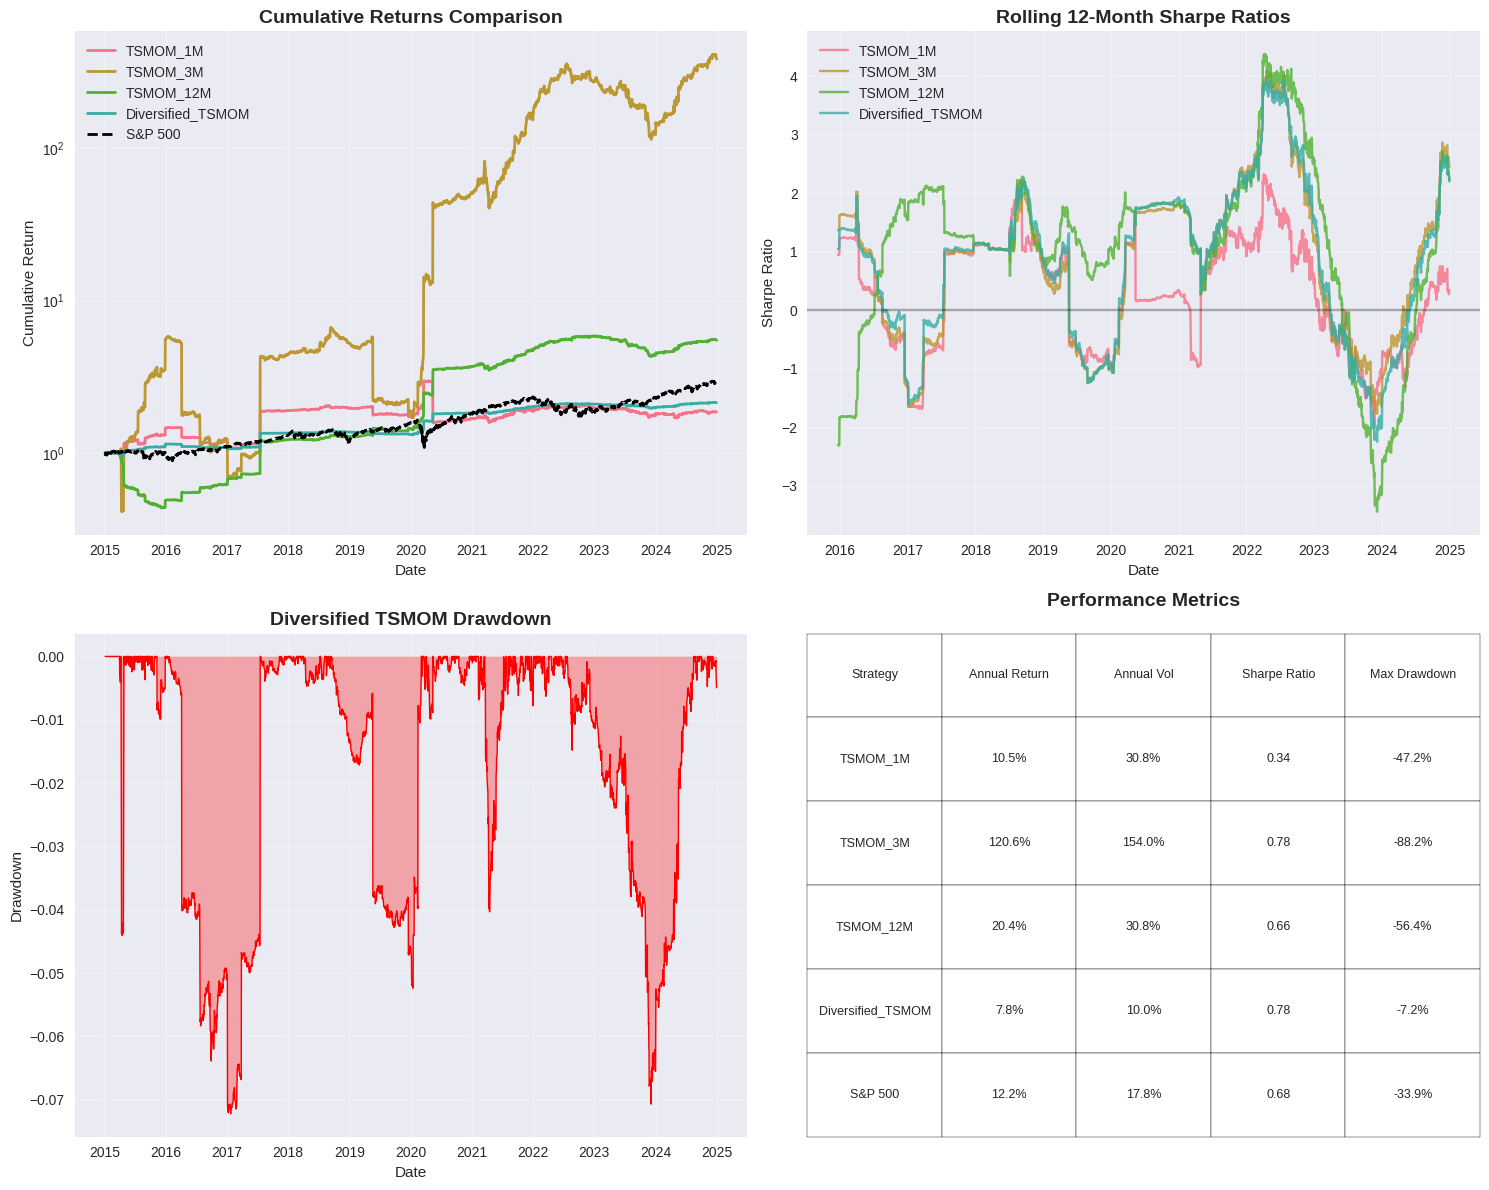

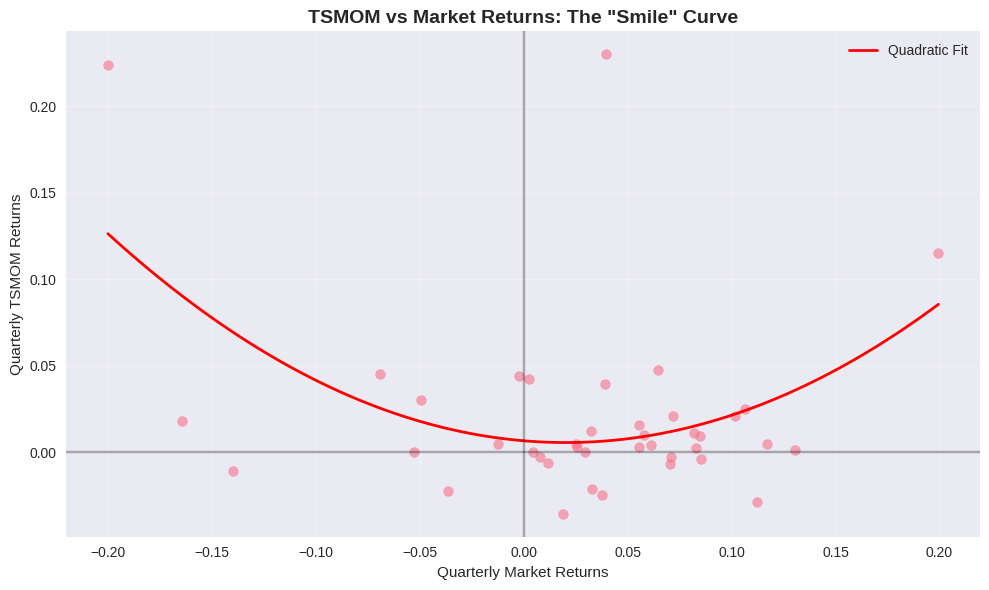


=== Strategy Implementation Complete ===
Note: This is a demonstration using simulated data.
For live trading, use real futures price data and consider:
- Transaction costs (1-4% annually)
- Management fees (typically 2% + 20% performance fee)
- Margin requirements (8-12% for institutional investors)
- Risk management procedures
- Rebalancing frequency optimization


In [31]:
# Main execution
if __name__ == "__main__":
    print("=== Time Series Momentum (TSMOM) Strategy Implementation ===")
    print("Based on 'A Century of Evidence on Trend-Following Investing' by Hurst et al.")
    print()

    # Initialize and run TSMOM strategy
    tsmom = TSMOMStrategyWithRiskLimits(
    lookback_periods=[1, 3, 12],
    target_vol=0.40,
    portfolio_vol=0.10,
    max_leverage=3.0,           # 최대 레버리지
    max_position_pct=0.2,      # 최대 포지션 크기
    max_drawdown=0.5,          # 최대 드로다운
    var_limit=1,             # VaR 제한
    stop_loss_pct=0.5,         # 손절매 수준
    max_correlation=1.00        # 최대 상관관계
)

    print("Running TSMOM strategy...")
    results = tsmom.run_strategy_with_risk_limits(prices_df, risk_free_rate=0.02)

    # Display performance metrics
    print("\n=== Performance Summary ===")
    for name, returns in results['individual_strategies'].items():
        metrics = calculate_performance_metrics(returns)
        print(f"\n{name}:")
        print(f"  Annual Return: {metrics.get('Annual Return', 0):.1%}")
        print(f"  Annual Volatility: {metrics.get('Annual Volatility', 0):.1%}")
        print(f"  Sharpe Ratio: {metrics.get('Sharpe Ratio', 0):.2f}")
        print(f"  Max Drawdown: {metrics.get('Max Drawdown', 0):.1%}")

    # Plot results
    print("\nGenerating performance charts...")
    sp500_returns = sp500_prices.pct_change().dropna()

    plot_performance_comparison(results, sp500_prices)
    plot_smile_curve(results['diversified_returns'], sp500_returns)

    print("\n=== Strategy Implementation Complete ===")
    print("Note: This is a demonstration using simulated data.")
    print("For live trading, use real futures price data and consider:")
    print("- Transaction costs (1-4% annually)")
    print("- Management fees (typically 2% + 20% performance fee)")
    print("- Margin requirements (8-12% for institutional investors)")
    print("- Risk management procedures")
    print("- Rebalancing frequency optimization")

In [24]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 15.0 MB/s eta 0:00:00


In [25]:
# TSMOM Strategy Bayesian Optimization
import numpy as np
import pandas as pd
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_contour
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

class TSMOMBayesianOptimizer:
    """
    Bayesian optimization for TSMOM strategy parameters
    """

    def __init__(self, prices_df, risk_free_rate=0.02, n_splits=5):
        """
        Initialize optimizer

        Parameters:
        -----------
        prices_df : pd.DataFrame
            Price data
        risk_free_rate : float
            Risk-free rate
        n_splits : int
            Number of splits for time series cross-validation
        """
        self.prices_df = prices_df
        self.risk_free_rate = risk_free_rate
        self.n_splits = n_splits
        self.tscv = TimeSeriesSplit(n_splits=n_splits)
        self.optimization_results = []

    def objective(self, trial):
        """
        Objective function for Bayesian optimization

        Parameters:
        -----------
        trial : optuna.Trial
            A trial object

        Returns:
        --------
        float : Negative Sharpe ratio (to minimize)
        """
        # Suggest parameters
        params = {
            'lookback_1': trial.suggest_int('lookback_1', 1, 3),
            'lookback_2': trial.suggest_int('lookback_2', 3, 9),
            'lookback_3': trial.suggest_int('lookback_3', 9, 18),
            'target_vol': trial.suggest_float('target_vol', 0.1, 0.6),
            'portfolio_vol': trial.suggest_float('portfolio_vol', 0.05, 0.20),
            'max_leverage': trial.suggest_float('max_leverage', 0.5, 3.0),
            'max_position_pct': trial.suggest_float('max_position_pct', 0.05, 0.30),
            'max_drawdown': trial.suggest_float('max_drawdown', 0.10, 0.50),
            'var_limit': trial.suggest_float('var_limit', 0.05, 0.30),
            'stop_loss_pct': trial.suggest_float('stop_loss_pct', 0.05, 0.25),
            'max_correlation': trial.suggest_float('max_correlation', 0.50, 0.95)
        }

        # Run cross-validation
        cv_sharpe_ratios = []

        for train_idx, test_idx in self.tscv.split(self.prices_df):
            try:
                # Split data
                train_prices = self.prices_df.iloc[train_idx]
                test_prices = self.prices_df.iloc[test_idx]

                # Skip if test set is too small
                if len(test_prices) < 60:
                    continue

                # Initialize strategy with suggested parameters
                strategy = TSMOMStrategyWithRiskLimits(
                    lookback_periods=[params['lookback_1'], params['lookback_2'], params['lookback_3']],
                    target_vol=params['target_vol'],
                    portfolio_vol=params['portfolio_vol'],
                    max_leverage=params['max_leverage'],
                    max_position_pct=params['max_position_pct'],
                    max_drawdown=params['max_drawdown'],
                    var_limit=params['var_limit'],
                    stop_loss_pct=params['stop_loss_pct'],
                    max_correlation=params['max_correlation']
                )

                # Train strategy (get parameters)
                train_results = strategy.run_strategy_with_risk_limits(train_prices, self.risk_free_rate)

                # Test strategy
                test_results = strategy.run_strategy_with_risk_limits(test_prices, self.risk_free_rate)

                # Calculate Sharpe ratio on test set
                test_returns = test_results['diversified_returns'].dropna()
                if len(test_returns) > 0:
                    sharpe_ratio = self._calculate_sharpe_ratio(test_returns)
                    cv_sharpe_ratios.append(sharpe_ratio)

            except Exception as e:
                # Handle any errors in strategy execution
                print(f"Error in trial {trial.number}: {str(e)}")
                continue

        # Return average CV Sharpe ratio (negative for minimization)
        if cv_sharpe_ratios:
            avg_sharpe = np.mean(cv_sharpe_ratios)

            # Store intermediate results
            self.optimization_results.append({
                'trial': trial.number,
                'params': params,
                'cv_sharpe_ratios': cv_sharpe_ratios,
                'avg_sharpe': avg_sharpe
            })

            return -avg_sharpe  # Negative because Optuna minimizes
        else:
            return float('inf')  # Return high value if strategy failed

    def _calculate_sharpe_ratio(self, returns):
        """Calculate annualized Sharpe ratio"""
        annual_return = returns.mean() * 252
        annual_vol = returns.std() * np.sqrt(252)
        return annual_return / annual_vol if annual_vol > 0 else 0

    def optimize(self, n_trials=100, n_jobs=1, seed=42):
        """
        Run Bayesian optimization

        Parameters:
        -----------
        n_trials : int
            Number of optimization trials
        n_jobs : int
            Number of parallel jobs (-1 for all cores)
        seed : int
            Random seed

        Returns:
        --------
        dict : Best parameters and optimization history
        """
        # Create study with TPE sampler (Tree-structured Parzen Estimator)
        study = optuna.create_study(
            direction='minimize',
            sampler=optuna.samplers.TPESampler(seed=seed),
            pruner=optuna.pruners.MedianPruner()
        )

        # Run optimization
        print(f"Starting Bayesian optimization with {n_trials} trials...")
        study.optimize(
            self.objective,
            n_trials=n_trials,
            n_jobs=n_jobs,
            show_progress_bar=True
        )

        # Get best parameters
        best_params = study.best_params
        best_value = -study.best_value  # Convert back to positive Sharpe ratio

        print(f"\nOptimization complete!")
        print(f"Best Sharpe Ratio: {best_value:.3f}")
        print(f"Best Parameters:")
        for param, value in best_params.items():
            print(f"  {param}: {value:.4f}" if isinstance(value, float) else f"  {param}: {value}")

        return {
            'best_params': best_params,
            'best_sharpe': best_value,
            'study': study,
            'optimization_results': self.optimization_results
        }

    def analyze_results(self, optimization_result, save_plots=True):
        """
        Analyze and visualize optimization results

        Parameters:
        -----------
        optimization_result : dict
            Result from optimize()
        save_plots : bool
            Whether to save plots to file
        """
        study = optimization_result['study']

        # Create figure with subplots
        fig = plt.figure(figsize=(20, 15))

        # 1. Optimization History
        ax1 = plt.subplot(3, 3, 1)
        trials = [t.number for t in study.trials]
        values = [-t.value for t in study.trials]  # Convert to positive Sharpe
        ax1.plot(trials, values, 'b-', alpha=0.5)
        ax1.scatter(trials, values, c=values, cmap='viridis', s=50)
        ax1.set_xlabel('Trial')
        ax1.set_ylabel('Sharpe Ratio')
        ax1.set_title('Optimization History')
        ax1.grid(True, alpha=0.3)

        # 2. Parameter Importance
        ax2 = plt.subplot(3, 3, 2)
        importance_data = []
        params = list(study.best_params.keys())

        # Calculate parameter importance manually
        for param in params:
            param_values = [t.params.get(param, np.nan) for t in study.trials if not np.isnan(t.value)]
            sharpe_values = [-t.value for t in study.trials if not np.isnan(t.value)]
            if len(param_values) > 1:
                correlation = np.corrcoef(param_values, sharpe_values)[0, 1]
                importance_data.append(abs(correlation))
            else:
                importance_data.append(0)

        ax2.barh(params, importance_data)
        ax2.set_xlabel('Importance (|Correlation|)')
        ax2.set_title('Parameter Importance')

        # 3. Best vs Worst Trials
        ax3 = plt.subplot(3, 3, 3)
        sorted_trials = sorted(study.trials, key=lambda t: t.value)
        best_5 = sorted_trials[:5]
        worst_5 = sorted_trials[-5:]

        best_sharpes = [-t.value for t in best_5]
        worst_sharpes = [-t.value for t in worst_5]

        x = np.arange(5)
        width = 0.35
        ax3.bar(x - width/2, best_sharpes, width, label='Best 5', color='green', alpha=0.7)
        ax3.bar(x + width/2, worst_sharpes, width, label='Worst 5', color='red', alpha=0.7)
        ax3.set_xlabel('Trial Rank')
        ax3.set_ylabel('Sharpe Ratio')
        ax3.set_title('Best vs Worst Trials')
        ax3.legend()

        # 4-6. Parameter Distributions
        param_names = ['target_vol', 'portfolio_vol', 'max_leverage']
        for i, param in enumerate(param_names):
            ax = plt.subplot(3, 3, 4 + i)
            param_values = [t.params.get(param, np.nan) for t in study.trials if not np.isnan(t.value)]
            sharpe_values = [-t.value for t in study.trials if not np.isnan(t.value)]

            scatter = ax.scatter(param_values, sharpe_values, c=sharpe_values, cmap='viridis', alpha=0.6)
            ax.axvline(study.best_params[param], color='red', linestyle='--', label='Best')
            ax.set_xlabel(param)
            ax.set_ylabel('Sharpe Ratio')
            ax.set_title(f'{param} vs Sharpe Ratio')
            ax.legend()

        # 7. Risk Parameters Distribution
        ax7 = plt.subplot(3, 3, 7)
        risk_params = ['max_drawdown', 'var_limit', 'stop_loss_pct']
        best_risk_values = [study.best_params[p] for p in risk_params]
        ax7.bar(risk_params, best_risk_values, color=['blue', 'green', 'red'])
        ax7.set_ylabel('Value')
        ax7.set_title('Best Risk Parameters')
        ax7.set_ylim(0, 0.6)

        # 8. Lookback Periods Analysis
        ax8 = plt.subplot(3, 3, 8)
        lookback_params = ['lookback_1', 'lookback_2', 'lookback_3']
        best_lookbacks = [study.best_params[p] for p in lookback_params]
        ax8.bar(lookback_params, best_lookbacks, color='purple')
        ax8.set_ylabel('Months')
        ax8.set_title('Best Lookback Periods')

        # 9. Convergence Analysis
        ax9 = plt.subplot(3, 3, 9)
        best_values = []
        current_best = float('-inf')
        for trial in study.trials:
            value = -trial.value
            if value > current_best:
                current_best = value
            best_values.append(current_best)

        ax9.plot(best_values, 'g-', linewidth=2)
        ax9.fill_between(range(len(best_values)), best_values, alpha=0.3, color='green')
        ax9.set_xlabel('Trial')
        ax9.set_ylabel('Best Sharpe Ratio')
        ax9.set_title('Convergence Plot')
        ax9.grid(True, alpha=0.3)

        plt.tight_layout()

        if save_plots:
            plt.savefig('tsmom_bayesian_optimization_results.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Print detailed statistics
        self._print_optimization_statistics(study)

        return fig

    def _print_optimization_statistics(self, study):
        """Print detailed optimization statistics"""
        print("\n" + "="*60)
        print("OPTIMIZATION STATISTICS")
        print("="*60)

        # Trial statistics
        print(f"\nTotal trials: {len(study.trials)}")
        completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
        print(f"Completed trials: {len(completed_trials)}")

        # Sharpe ratio statistics
        sharpe_values = [-t.value for t in completed_trials]
        print(f"\nSharpe Ratio Statistics:")
        print(f"  Best: {np.max(sharpe_values):.3f}")
        print(f"  Mean: {np.mean(sharpe_values):.3f}")
        print(f"  Std: {np.std(sharpe_values):.3f}")
        print(f"  Median: {np.median(sharpe_values):.3f}")

        # Parameter ranges
        print(f"\nOptimal Parameter Ranges (top 10% trials):")
        top_10_pct = int(len(completed_trials) * 0.1)
        top_trials = sorted(completed_trials, key=lambda t: t.value)[:top_10_pct]

        for param in study.best_params.keys():
            values = [t.params[param] for t in top_trials]
            if isinstance(values[0], float):
                print(f"  {param}: {np.min(values):.3f} - {np.max(values):.3f} (best: {study.best_params[param]:.3f})")
            else:
                print(f"  {param}: {np.min(values)} - {np.max(values)} (best: {study.best_params[param]})")

    def save_results(self, optimization_result, filename='tsmom_optimization_results.json'):
        """Save optimization results to file"""
        results_to_save = {
            'best_params': optimization_result['best_params'],
            'best_sharpe': optimization_result['best_sharpe'],
            'optimization_history': [
                {
                    'trial': r['trial'],
                    'params': r['params'],
                    'avg_sharpe': r['avg_sharpe']
                }
                for r in optimization_result['optimization_results']
            ],
            'timestamp': datetime.now().isoformat()
        }

        with open(filename, 'w') as f:
            json.dump(results_to_save, f, indent=4)

        print(f"\nResults saved to {filename}")


# Main execution function
def run_bayesian_optimization(prices_df, n_trials=100, n_jobs=-1):
    """
    Run Bayesian optimization for TSMOM strategy

    Parameters:
    -----------
    prices_df : pd.DataFrame
        Price data
    n_trials : int
        Number of optimization trials
    n_jobs : int
        Number of parallel jobs

    Returns:
    --------
    dict : Optimization results including best parameters
    """
    print("="*60)
    print("TSMOM BAYESIAN PARAMETER OPTIMIZATION")
    print("="*60)
    print(f"\nData period: {prices_df.index[0]} to {prices_df.index[-1]}")
    print(f"Number of assets: {len(prices_df.columns)}")
    print(f"Number of trials: {n_trials}")
    print(f"Cross-validation splits: 5")
    print()

    # Initialize optimizer
    optimizer = TSMOMBayesianOptimizer(prices_df, risk_free_rate=0.02, n_splits=5)

    # Run optimization
    optimization_result = optimizer.optimize(n_trials=n_trials, n_jobs=n_jobs)

    # Analyze results
    optimizer.analyze_results(optimization_result)

    # Save results
    optimizer.save_results(optimization_result)

    # Create optimized strategy with best parameters
    print("\n" + "="*60)
    print("RUNNING OPTIMIZED STRATEGY")
    print("="*60)

    best_params = optimization_result['best_params']
    optimized_strategy = TSMOMStrategyWithRiskLimits(
        lookback_periods=[
            best_params['lookback_1'],
            best_params['lookback_2'],
            best_params['lookback_3']
        ],
        target_vol=best_params['target_vol'],
        portfolio_vol=best_params['portfolio_vol'],
        max_leverage=best_params['max_leverage'],
        max_position_pct=best_params['max_position_pct'],
        max_drawdown=best_params['max_drawdown'],
        var_limit=best_params['var_limit'],
        stop_loss_pct=best_params['stop_loss_pct'],
        max_correlation=best_params['max_correlation']
    )

    # Run optimized strategy on full dataset
    optimized_results = optimized_strategy.run_strategy_with_risk_limits(prices_df)

    # Display performance
    print("\nOptimized Strategy Performance:")
    risk_metrics = optimized_results['risk_metrics']['Diversified_TSMOM']
    for metric, value in risk_metrics.items():
        if isinstance(value, float):
            if 'Return' in metric or 'Vol' in metric:
                print(f"  {metric}: {value:.1%}")
            else:
                print(f"  {metric}: {value:.3f}")

    return {
        'optimization_result': optimization_result,
        'optimized_strategy': optimized_strategy,
        'optimized_results': optimized_results
    }


# Example usage
if __name__ == "__main__":
    # Load your data
    # prices_df = pd.read_csv('tsmom_fixed_data.csv', index_col='Date', parse_dates=True)

    # Run optimization
    # results = run_bayesian_optimization(prices_df, n_trials=100, n_jobs=-1)

    print("\nNote: This optimization process may take several hours depending on:")
    print("- Number of trials")
    print("- Number of CPU cores")
    print("- Size of the dataset")
    print("\nRecommended settings:")
    print("- Quick test: n_trials=20")
    print("- Standard optimization: n_trials=100")
    print("- Thorough optimization: n_trials=500+")


Note: This optimization process may take several hours depending on:
- Number of trials
- Number of CPU cores
- Size of the dataset

Recommended settings:
- Quick test: n_trials=20
- Standard optimization: n_trials=100
- Thorough optimization: n_trials=500+


In [27]:
# 베이지안 최적화 실행
results = run_bayesian_optimization(
    prices_df,
    n_trials=10,  # 시도 횟수
    n_jobs=-1      # 모든 CPU 코어 사용
)

# 최적화된 파라미터로 전략 실행
best_params = results['optimization_result']['best_params']
print(f"Best Sharpe Ratio: {results['optimization_result']['best_sharpe']:.3f}")
print("Best Parameters:", best_params)

[I 2025-06-18 14:48:49,370] A new study created in memory with name: no-name-672dc47c-cc11-481f-8626-290e8b649412


TSMOM BAYESIAN PARAMETER OPTIMIZATION

Data period: 2015-01-02 00:00:00 to 2024-12-30 00:00:00
Number of assets: 48
Number of trials: 10
Cross-validation splits: 5

Starting Bayesian optimization with 10 trials...


  0%|          | 0/10 [00:00<?, ?it/s]

Calculating returns and volatility...
Calculating returns and volatility...
Running 3-month TSMOM with risk limits...
Running 1-month TSMOM with risk limits...
  Applying leverage limits...
  Applying drawdown control...
  Applying VaR limits...
  Applying leverage limits...
  Applying drawdown control...
  Applying VaR limits...
  Applying correlation limits...
Running 7-month TSMOM with risk limits...
  Applying correlation limits...
Running 6-month TSMOM with risk limits...
  Applying leverage limits...
  Applying drawdown control...
  Applying VaR limits...
  Applying leverage limits...
  Applying drawdown control...
  Applying VaR limits...
  Applying correlation limits...
Running 16-month TSMOM with risk limits...
  Applying correlation limits...
Running 18-month TSMOM with risk limits...
  Applying leverage limits...
  Applying drawdown control...
  Applying VaR limits...
  Applying leverage limits...
  Applying drawdown control...
  Applying VaR limits...
  Applying correlation

KeyboardInterrupt: 